# Build a classifier to predict which customers are Uber regular rider.
Your notebook should include:
* Data loading
* Preprocessing: missing data, outliers, categorical variable processing, ...
* Choosing the hyperparameter space and perform the grid search for hyperparameters optimization
* Print the confusion metrics and performance metrics (accuracy, f1-score, auc)

## 1. Importing libraries and loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy.stats import norm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/pnhuy/datasets/master/vefa/uber_usage.csv")

## 2. EDA

In [3]:
data

,CustomerID,Gender,Age,AnnualSalary,RegularRider
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    400 non-null    int64 
 1   Gender        400 non-null    object
 2   Age           400 non-null    int64 
 3   AnnualSalary  400 non-null    int64 
 4   RegularRider  400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [5]:
data.describe()
# No non-positive value for Age and Annual Salary

,CustomerID,Age,AnnualSalary,RegularRider
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [6]:
# Check if there are any missing values
data.isnull().any()

CustomerID      False
Gender          False
Age             False
AnnualSalary    False
RegularRider    False
dtype: bool

Text(0.5, 1.0, 'The number of Regular and Irregular Riders')

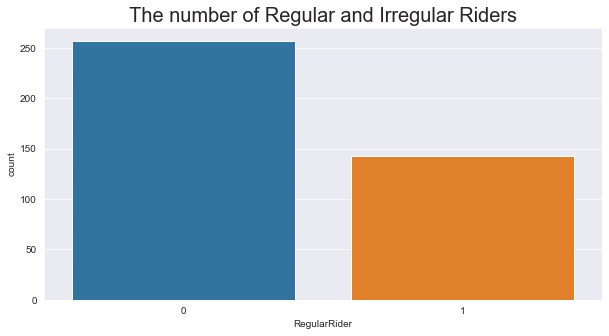

In [7]:
# Visualize the proportion of Regular Rider
plt.figure(figsize=(10, 5))
sns.countplot(x=data['RegularRider'])
plt.title('The number of Regular and Irregular Riders', fontsize=20)

* The number of Regular Rider is approximately half of Irregular one => choose class_weight='balanced' in the classifier.

Norm dist of Age (mu = 37.66, sigma = 10.47)
Norm dist of Annual Salary (mu = 69742.50, sigma = 34054.31)


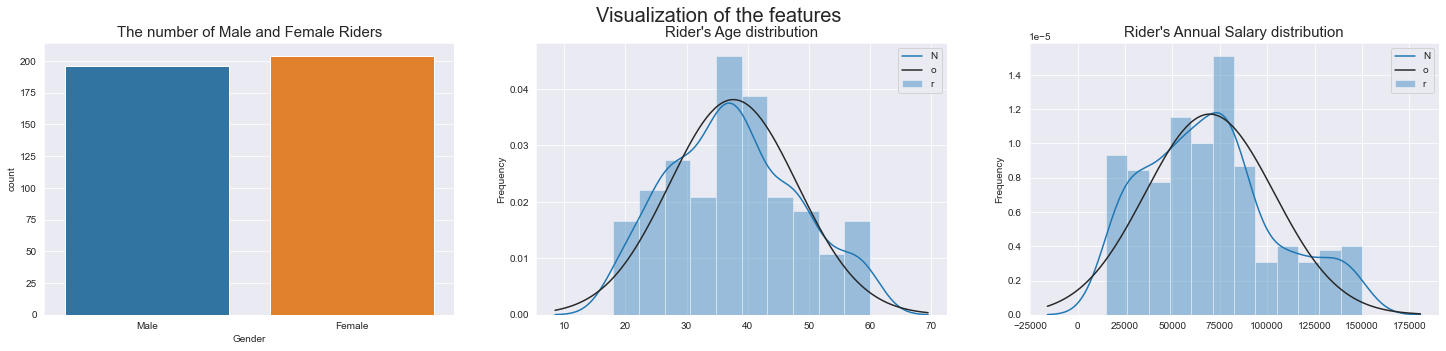

In [8]:
# Visualize Gender, Age and Annual Salary
fig, axes = plt.subplots(1, 3, figsize=(25,5))
fig.suptitle("Visualization of the features", fontsize=20)

## Gender
sns.countplot(ax=axes[0], x=data['Gender'])
axes[0].set_title("The number of Male and Female Riders", fontsize=15)

## Age
mu, sigma = norm.fit(data['Age'])
sns.distplot(ax=axes[1], x=data['Age'], fit=norm)
axes[1].set_title("Rider's Age distribution", fontsize=15)
axes[1].legend("Norm dist ($\mu=$ {:.2f}, $\sigma=$ {:.2f})".format(mu, sigma), loc="best")
axes[1].set_ylabel("Frequency")
print("Norm dist of Age (mu = {:.2f}, sigma = {:.2f})".format(mu, sigma))

## Annual Salary
mu, sigma = norm.fit(data['AnnualSalary'])
sns.distplot(ax=axes[2], x=data['AnnualSalary'], fit=norm)
axes[2].set_title("Rider's Annual Salary distribution", fontsize=15)
axes[2].legend("Norm dist ($\mu=$ {:.2f}, $\sigma=$ {:.2f})".format(mu, sigma), loc="best")
axes[2].set_ylabel("Frequency")
print("Norm dist of Annual Salary (mu = {:.2f}, sigma = {:.2f})".format(mu, sigma))

* "Gender" feature has a nearly equal proportion between the Male and Female.
* Feature "Age" and "AnnualSalary" show no outliers. And they are not normally distributed (Shapiro-Wilk test). However, this is not a required assumption of classification model.

<AxesSubplot:>

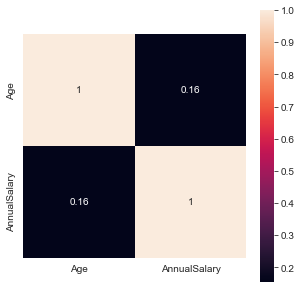

In [9]:
# Check the correlation between Age and AnnualSalary features
corr_matrix = data[['Age', 'AnnualSalary']].corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True)

* The 'Age' and 'AnnualSalary' features show no multicollinearity (correlation coefficient = 0.16) => we can use both these 2 features to train the model.

## 3. Modelling

### 3.1. Feature engineering and splitting dataset

In [10]:
X = data.drop(columns=['CustomerID', 'RegularRider'])
y = data['RegularRider']

In [11]:
# One Hot Encoding for categorical feature ("Gender")
X = pd.get_dummies(X, drop_first=True)

In [12]:
# Split the dataset to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

In [13]:
# Standard scale the numerical features ("Age", "AnnualSalary")
sc = StandardScaler()
X_train.iloc[:, :-1] = sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = sc.transform(X_test.iloc[:, :-1])

### 3.2. Logistic regression

#### 3.2.1. Without hyperparameter tuning

In [14]:
logreg = LogisticRegression(class_weight='balanced') # because y value is imbalanced
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85        77
           1       0.71      0.84      0.77        43

    accuracy                           0.82       120
   macro avg       0.80      0.82      0.81       120
weighted avg       0.83      0.82      0.82       120



In [15]:
# Print the AUC score
y_score = logreg.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_score)
print("AUC = {}".format(auc_score))

AUC = 0.9109030504379341


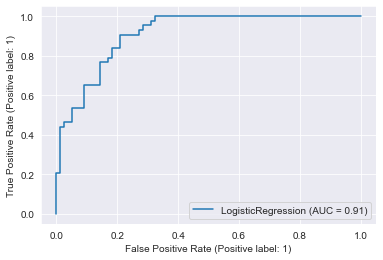

In [16]:
# Plot the ROC
plot_roc_curve(logreg, X_test, y_test)

#### 3.2.2. With hyperparameter tuning

In [17]:
logreg = LogisticRegression()
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 5, 10, 100, 500],
    'class_weight': ['balanced']
}

grid = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', verbose=True, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [18]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85        77
           1       0.71      0.84      0.77        43

    accuracy                           0.82       120
   macro avg       0.80      0.82      0.81       120
weighted avg       0.83      0.82      0.82       120



In [19]:
# Print the AUC score
y_score = best_model.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_score)
print("AUC = {}".format(auc_score))

AUC = 0.9109030504379341


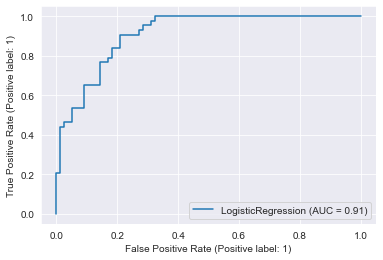

In [20]:
# Plot the ROC
plot_roc_curve(best_model, X_test, y_test)

### 3.3. SVM

#### 3.3.1. Without hyperparameter tuning

In [21]:
svc = SVC(class_weight='balanced') # because y value is imbalanced
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        77
           1       0.82      0.93      0.87        43

    accuracy                           0.90       120
   macro avg       0.89      0.91      0.89       120
weighted avg       0.91      0.90      0.90       120



In [22]:
# Print the AUC score
y_score = svc.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_score)
print("AUC = {}".format(auc_score))

AUC = 0.9758381153729991


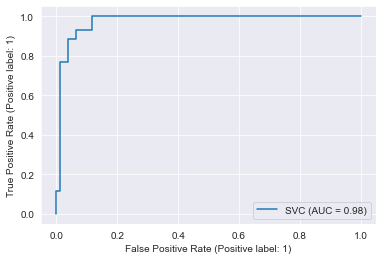

In [23]:
# Plot the ROC
plot_roc_curve(svc, X_test, y_test)

#### 3.3.2. Hyperparameter for SVM

In [24]:
svc = SVC()
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 50.0],
    'class_weight': ['balanced'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

grid = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc', verbose=True, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'C': 1.0, 'class_weight': 'balanced', 'kernel': 'rbf'}

In [25]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        77
           1       0.82      0.93      0.87        43

    accuracy                           0.90       120
   macro avg       0.89      0.91      0.89       120
weighted avg       0.91      0.90      0.90       120



In [26]:
# Print the AUC score
y_score = best_model.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_score)
print("AUC = {}".format(auc_score))

AUC = 0.9758381153729991


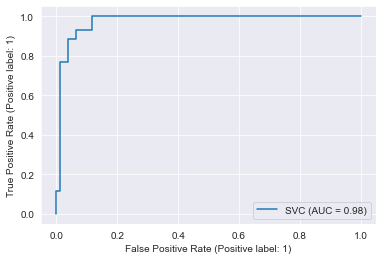

In [27]:
# Plot the ROC
plot_roc_curve(best_model, X_test, y_test)

#### Based on the f1-score and AUC, SVM (with hyperparameter {'C': 1.0, 'class_weight': 'balanced', 'kernel': 'rbf'}) is a better model than Logistic regression for this dataset.